In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [34]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 3600]
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)

#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())
# Если в одном из событий не было волонтёров, добавим колонки с 0  



record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              161787
snow.1h                              169059
track_description_surface       

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [35]:
columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  


In [36]:
starts.loc[:,'is_repeated'] = starts.groupby('athlete_id')['event_date'].transform(lambda x: x.count() > 1)
starts['is_newbie'] = starts['is_newbie'].astype(int)
starts['is_repeated'] = starts['is_repeated'].astype(int)

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [37]:
starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [38]:
starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-11-15']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8956
кол-во новичков, которые пришли во 2 раз: 10534
кол-во новичков, которые не пришли после 1 раза: 9929


In [39]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = newbie[newbie.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

10534 9929


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated
113325,4809,790126867,Стрелка,2023-01-01,Ярославль,Ярославская область,1508,женский,45,1,0.7,-3.42,1005,100,0.7,100,4.0,210,Snow,light snow,NaN,0.36,тротуарная плитка,0,0.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
113510,4809,790126911,Стрелка,2023-01-01,Ярославль,Ярославская область,1932,женский,38,1,0.7,-3.42,1005,100,0.7,100,4.0,210,Snow,light snow,NaN,0.36,тротуарная плитка,0,0.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [40]:
come_with_didnt_come = pd.concat([come, didnt_come])
num_col = come_with_didnt_come.select_dtypes('number')

come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)

print(num_col.corr()['is_repeated'])
display(come_with_didnt_come.head(2))


record_id                           -0.140772
athlete_id                          -0.128724
finish_time                         -0.094882
athlete_age                          0.097295
is_newbie                                 NaN
temp                                -0.027663
feels_like                          -0.032000
pressure                            -0.005596
humidity                            -0.037091
dew_point                           -0.044564
clouds                              -0.026409
wind_speed                           0.030024
wind_deg                             0.032425
rain.1h                              0.114858
snow.1h                             -0.025691
is_male                              0.037958
discomfort_index                    -0.031215
Ведущий велосипед                   -0.029316
Завершение мероприятия              -0.023564
Замыкающий                          -0.111126
Инструктаж новых участников         -0.036371
Координатор парковки              

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
78868,4755,790111628,Курган Центральный парк,2023-01-01,Курган,Курганская область,2783,женский,36,1,-30.18,-30.18,1034,75,-32.91,79,1.29,30,Clouds,broken clouds,NaN,NaN,твердое,0,-24.03650,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,10.0
109557,4812,790125640,Битца,2023-01-01,Москва,Москва,2060,женский,46,1,1.01,-3.90,1008,98,0.73,100,5.46,215,Clouds,overcast clouds,NaN,NaN,грунт,0,1.15839,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1,14.0


Откинем не стат значимые корреляции и сделаем логит модель.

In [41]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  

D:\Anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))



Неподходящие целочисленные переменные: ['temp', 'discomfort_index', 'Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Пейсер', 'Составление отчёта', 'Сурдопереводчик']
8


In [44]:
num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
'humidity','clouds', 'wind_speed', 'wind_deg'
])
X = num_col_logit
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.661808
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                20463
Model:                          Logit   Df Residuals:                    20436
Method:                           MLE   Df Model:                           26
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.04461
Time:                        12:52:40   Log-Likelihood:                -13543.
converged:                       True   LL-Null:                       -14175.
Covariance Type:            nonrobust   LLR p-value:                2.053e-250
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 6.1781      1.735      3

In [45]:

num_col_starts['cnt_volunteers'] = num_col_starts.iloc[:, 17:39].sum(axis=1)
num_col_starts.head(3)


,record_id,athlete_id,finish_time,athlete_age,is_newbie,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,rain.1h,snow.1h,is_male,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координация волонтёров,Маршал,Обработка результатов,Организатор,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
78868,4755,790111628,2783,36,1,-30.18,1034,75,-32.91,79,1.29,30,NaN,NaN,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,10.0
109557,4812,790125640,2060,46,1,-3.90,1008,98,0.73,100,5.46,215,NaN,NaN,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1,15.0
110221,4782,790125851,1940,37,1,-3.68,1025,87,-0.16,75,7.00,260,NaN,NaN,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1,11.0


In [46]:
X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

#но у нас потенциально discomfort_index не линейно влияет на is_repeated, тк слишком низкий и слишком высокий discomfort_index должен понижать is_repeated, а по серединке идеально и будет повышать..
#... is repeated.

KeyError: "['discomfort_index'] not in index"

In [ ]:
# поэтому попробую полиномиальные признаки сделать

from sklearn.preprocessing import PolynomialFeatures  

X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age', 'finish_time', 'is_male']]  
y = num_col_starts['is_repeated']  

# Создаем полиномиальные признаки  
poly = PolynomialFeatures(degree=2, include_bias=False)  
X_poly = poly.fit_transform(X)  

# Получаем имена новых признаков  
feature_names = poly.get_feature_names_out(input_features=X.columns)  

# Создаем DataFrame с новыми признаками  
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)  

# Устанавливаем индексы для X_poly_df, чтобы они совпадали с y  
X_poly_df.index = y.index  

# Добавляем константу  
X_poly_df = sm.add_constant(X_poly_df)  

# Обучаем логистическую регрессию  
model = sm.Logit(y, X_poly_df).fit()  

# Выводим результаты  
print(model.summary())  


Optimization terminated successfully.
         Current function value: 0.666627
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                21940
Model:                          Logit   Df Residuals:                    21920
Method:                           MLE   Df Model:                           19
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.03826
Time:                        12:35:15   Log-Likelihood:                -14626.
converged:                       True   LL-Null:                       -15208.
Covariance Type:            nonrobust   LLR p-value:                5.871e-235
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.5025      0.402     -3.741  

Теперь будем создавать модель не просто на всех данных, а по кластерам (Маргарита их сделала)

In [ ]:
clst_1 = ['Архангельская область',
 'Архангельская область без автономного округа',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Ивановская область',
 'Калининградская область',
 'Калужская область',
 'Кировская область',
 'Костромская область',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Новгородская область',
 'Омская область',
 'Оренбургская область',
 'Орловская область',
 'Пензенская область',
 'Псковская область',
 'Республика Карелия',
 'Республика Коми',
 'Республика Крым',
 'Республика Марий Эл',
 'Республика Мордовия',
 'Рязанская область',
 'Саратовская область',
 'Смоленская область',
 'Ставропольский край',
 'Тамбовская область',
 'Тверская область',
 'Томская область',
 'Тульская область',
 'Удмуртская Республика',
 'Ульяновская область',
 'Чувашская Республика',
 'Ярославская область']


for_clst_1 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_1)]
X = for_clst_1[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_1['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.677736
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5395
Model:                          Logit   Df Residuals:                     5389
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.01934
Time:                        12:35:15   Log-Likelihood:                -3656.4
converged:                       True   LL-Null:                       -3728.5
Covariance Type:            nonrobust   LLR p-value:                 2.284e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6397      0.184      3.474      0.001       0.279       1.001
cnt_volunte

In [ ]:
# ВТОРОЙ КЛАСТЕР
clst_2 = ['Алтайский край',
 'Иркутская область',
 'Кемеровская область',
 'Краснодарский край',
 'Красноярский край',
 'Нижегородская область',
 'Новосибирская область',
 'Пермский край',
 'Приморский край',
 'Республика Башкортостан',
 'Республика Татарстан',
 'Ростовская область',
 'Самарская область',
 'Свердловская область',
 'Тюменская область',
 'Челябинская область']

for_clst_2 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_2)]
X = for_clst_2[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_2['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.657398
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8484
Model:                          Logit   Df Residuals:                     8478
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.04746
Time:                        12:35:16   Log-Likelihood:                -5577.4
converged:                       True   LL-Null:                       -5855.3
Covariance Type:            nonrobust   LLR p-value:                7.058e-118
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5692      0.143      3.989      0.000       0.290       0.849
cnt_volunte

In [ ]:
# ТРЕТИЙ КЛАСТЕР
clst_3 = ['Амурская область',
 'Астраханская область',
 'Еврейская автономная область',
 'Забайкальский край',
 'Кабардино-Балкарская Республика',
 'Камчатский край',
 'Карачаево-Черкесская Республика',
 'Магаданская область',
 'Мурманская область',
 'Республика Адыгея',
 'Республика Алтай',
 'Республика Бурятия',
 'Республика Калмыкия',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия — Алания',
 'Республика Тыва',
 'Республика Хакасия',
 'Сахалинская область',
 'Севастополь',
 'Тюменская область без автономных округов',
 'Хабаровский край',
 'Ханты-Мансийский автономный округ — Югра']
for_clst_3 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_3)]
X = for_clst_3[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_3['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.606974
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                  359
Model:                          Logit   Df Residuals:                      353
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1160
Time:                        12:35:16   Log-Likelihood:                -217.90
converged:                       True   LL-Null:                       -246.49
Covariance Type:            nonrobust   LLR p-value:                 4.644e-11
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3015      0.783      0.385      0.700      -1.234       1.837
cnt_volunte

In [ ]:
# ЧЕТВЕРТЫЙ КЛАСТЕР
clst_4 = ['Республика Дагестан', 'Республика Ингушетия', 'Чеченская Республика']
for_clst_4 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_4)]
X = for_clst_4[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_4['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

#В ЭТИХ РЕГИОНОВ ВООБЩЕ НЕТ 5 ВЕРСТ

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# 5 кластер
clst_5 = ['Ненецкий автономный округ',
 'Чукотский автономный округ',
 'Ямало-Ненецкий автономный округ']

for_clst_5 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_5)]
X = for_clst_5[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_5['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


#ТОЖЕ НЕТ ТАКИХ РЕГИОНОВ В 5 ВЕРСТ

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
clst_6 = ['Москва', 'Московская область', 'Санкт-Петербург']
for_clst_6 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_6)]
X = for_clst_6[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_6['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.682973
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 7702
Model:                          Logit   Df Residuals:                     7696
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.01365
Time:                        12:35:55   Log-Likelihood:                -5260.3
converged:                       True   LL-Null:                       -5333.1
Covariance Type:            nonrobust   LLR p-value:                 1.129e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2317      0.158      1.467      0.142      -0.078       0.541
cnt_volunte

Если выше я работал с отдельными новичками и предсказываением придет ли он во 2 раз или нет, то щас будет уже работа  с отдельной пробежкой и сколько человек после нее придет/не придет

In [47]:
cnt_ludei = starts.groupby(['event_name', 'event_date']).agg(
    cnt_runners = ('athlete_id', 'count'),
    region = ('region', 'last'),
    discomfort_index = ('discomfort_index','last')
)

info_about_jogging = first_runs.groupby(['event_name', 'event_date']).agg(
    pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 1])),
    ne_pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 0])),
    vsego_newbie = ('athlete_id', 'count'), 
    region = ('region', 'last')
).reset_index()
info_about_jogging = info_about_jogging.merge(cnt_ludei, on=['event_date', 'event_name', 'region'], how='left')
info_about_jogging = info_about_jogging.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

info_about_jogging = info_about_jogging.fillna(0)
info_about_jogging['otnos_ne_pridut'] = info_about_jogging['ne_pridut'] / info_about_jogging['vsego_newbie']

print(len(info_about_jogging))
info_about_jogging['cnt_volunteers'] = info_about_jogging.iloc[:, 8:35].sum(axis=1)

display(info_about_jogging.head(5))


3784


,event_name,event_date,pridut,ne_pridut,vsego_newbie,region,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
0,Александрино,2023-04-08,10,10,20,Санкт-Петербург,89,6.28660,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.500000,11.0
1,Александрино,2023-04-15,5,4,9,Санкт-Петербург,21,6.67771,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.444444,10.0
2,Александрино,2023-04-22,4,2,6,Санкт-Петербург,15,11.58912,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,8.0
3,Александрино,2023-04-29,6,1,7,Санкт-Петербург,22,6.01066,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.142857,8.0
4,Александрино,2023-05-06,4,2,6,Санкт-Петербург,28,7.70362,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,8.0


In [49]:
coef, p_value = stats.spearmanr(info_about_jogging['otnos_ne_pridut'], info_about_jogging['discomfort_index'])
print(coef, p_value)

0.12734653485700032 3.748394311712367e-15


Text(0.5, 1.0, 'Распределение кол-ва волонтеров на пробежке')

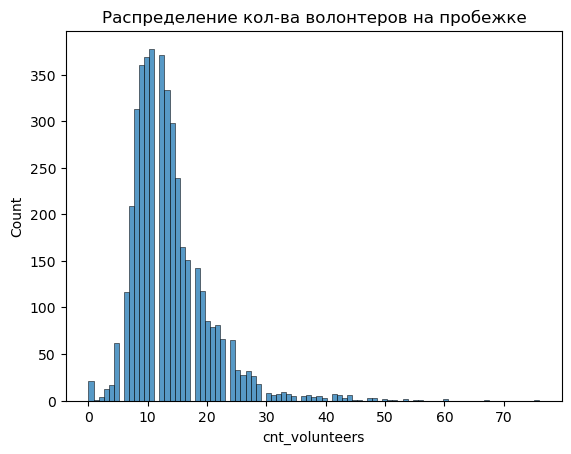

In [ ]:
sns.histplot(x=info_about_jogging.cnt_volunteers)
plt.title('Распределение кол-ва волонтеров на пробежке')

Text(0.5, 1.0, 'Распределение доли не придущих новичков на 2 пробежку')

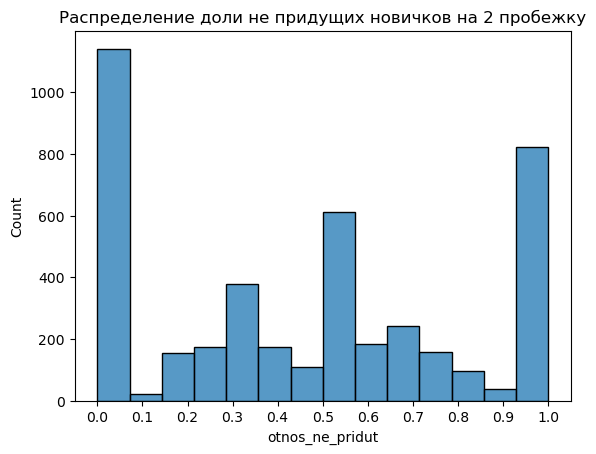

In [ ]:
sns.histplot(x=info_about_jogging.otnos_ne_pridut)
plt.xticks([(i/10) for i in range(0, 11)])
plt.title('Распределение доли не придущих новичков на 2 пробежку')

In [ ]:
info_about_jogging[info_about_jogging['otnos_ne_pridut']==0].head(10) 

,event_name,event_date,pridut,ne_pridut,vsego_newbie,region,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
10,Александрино,2023-06-17,2,0,2,Санкт-Петербург,22,19.629920,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0
15,Александрино,2023-07-22,3,0,3,Санкт-Петербург,25,17.393320,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
17,Александрино,2023-08-05,2,0,2,Санкт-Петербург,27,19.321720,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0
24,Александрино,2023-09-30,1,0,1,Санкт-Петербург,22,15.732880,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
25,Александрино,2023-10-07,2,0,2,Санкт-Петербург,21,5.384980,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,12.0
28,Александрино,2023-11-11,2,0,2,Санкт-Петербург,30,6.154180,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
34,Бабушкинский на Яузе,2023-01-14,1,0,1,Москва,25,-2.219295,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
36,Бабушкинский на Яузе,2023-01-28,1,0,1,Москва,26,-2.741610,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
38,Бабушкинский на Яузе,2023-02-18,1,0,1,Москва,30,-6.468300,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,19.0
39,Бабушкинский на Яузе,2023-03-04,2,0,2,Москва,18,-2.650640,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


Text(0, 0.5, 'кол-во всего бегунов на пробежке')

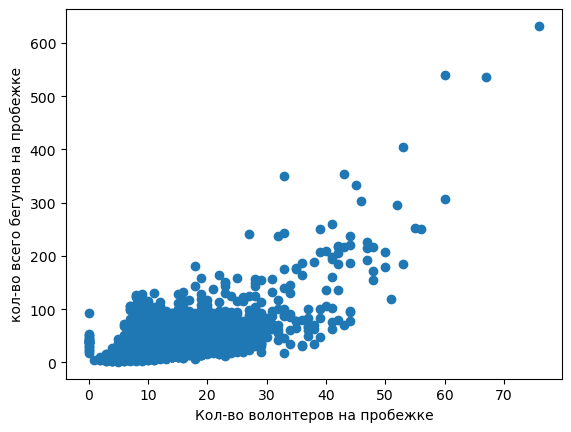

In [ ]:
plt.scatter(x=info_about_jogging.cnt_volunteers, y=info_about_jogging.cnt_runners)
plt.xlabel('Кол-во волонтеров на пробежке')
plt.ylabel('кол-во всего бегунов на пробежке')


<Axes: xlabel='discomfort_index', ylabel='Count'>

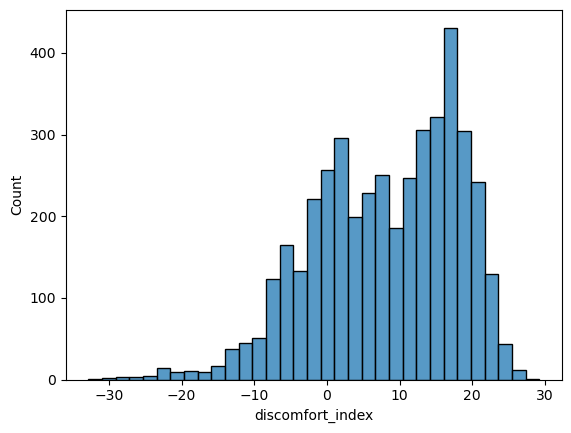

In [ ]:
sns.histplot(x=info_about_jogging.discomfort_index)

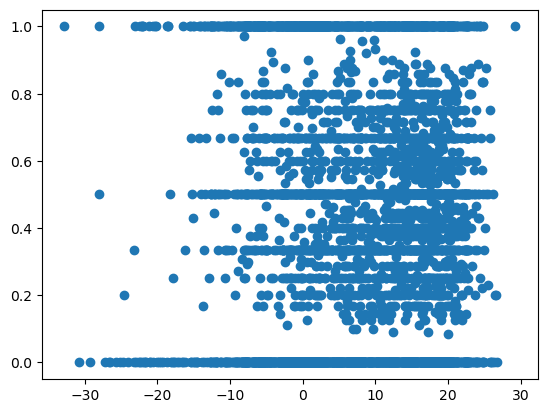

In [ ]:
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.otnos_ne_pridut)


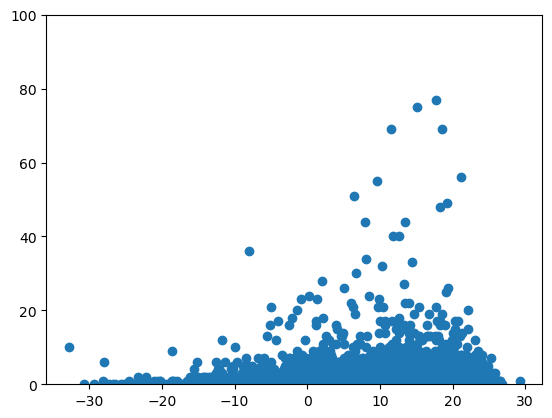

In [ ]:
plt.ylim(0, 100)
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.ne_pridut)


<Axes: title={'center': 'распред финиш тайм для новичков которые придут во 2 раз'}, xlabel='finish_time', ylabel='Count'>

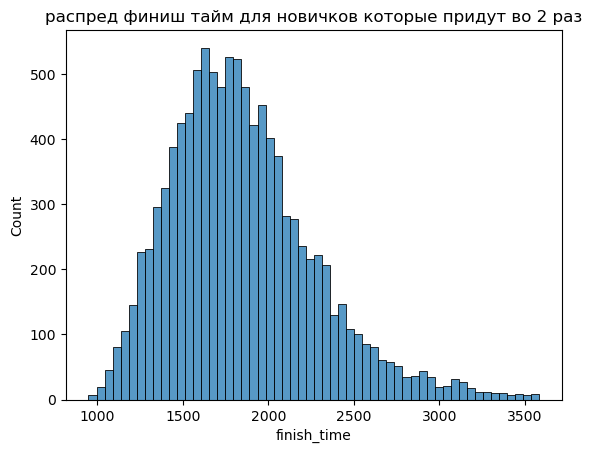

In [55]:
plt.title('распред финиш тайм для новичков которые придут во 2 раз')
sns.histplot(first_runs[first_runs.is_repeated==1].finish_time)

<Axes: title={'center': 'распред финиш тайм для новичков которые НЕ придут больше'}, xlabel='finish_time', ylabel='Count'>

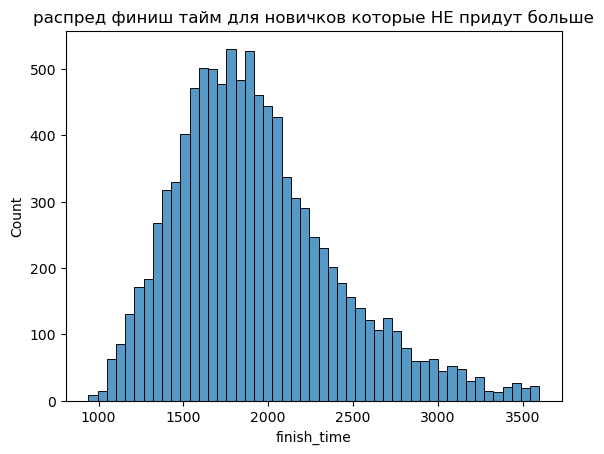

In [54]:
plt.title('распред финиш тайм для новичков которые НЕ придут больше')
sns.histplot(first_runs[first_runs.is_repeated==0].finish_time)

In [57]:
stat, p_value = stats.mannwhitneyu(first_runs[first_runs.is_repeated==0].finish_time, first_runs[first_runs.is_repeated==1].finish_time)  

# Выводим результаты  
print(f'Statistic: {stat}, p-value: {p_value}')  
print(first_runs[first_runs.is_repeated==1].finish_time.mean(), first_runs[first_runs.is_repeated==0].finish_time.mean())
# Интерпретируем результаты  
alpha = 0.05  
if p_value < alpha:  
    print('Отвергаем нулевую гипотезу: средние выборок статистически различаются.')  
else:  
    print('Не удалось отвергнуть нулевую гипотезу: средние выборок не различаются.')  

Statistic: 57450114.0, p-value: 2.965100874425344e-34
1846.8533320675906 1932.1440225601773
Отвергаем нулевую гипотезу: средние выборок статистически различаются.


D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

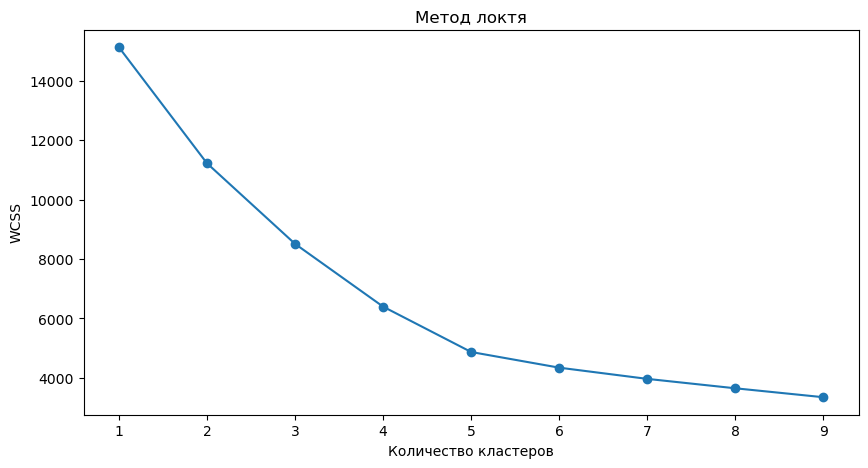

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   cluster  cnt_volunteers  vsego_newbie  ne_pridut
0        0       13.284292      5.434133   2.547759
1        1       12.837194      3.197220   1.324289
2        2       38.390625     56.687500  35.937500


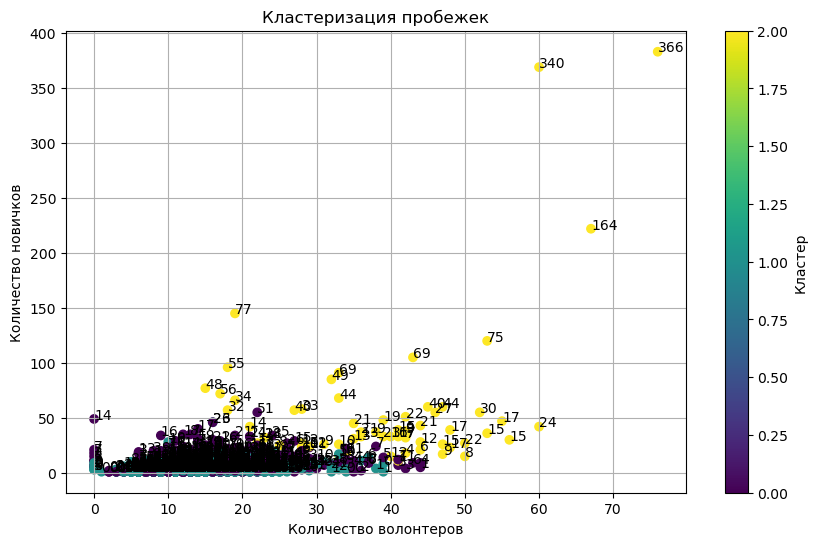

In [58]:
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler


# 2. Подготовьте данные для кластеризации  
X = info_about_jogging[['cnt_volunteers', 'vsego_newbie', 'cnt_runners', 'discomfort_index']].values  

# Стандартизация данных (это важно для K-Means)  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  

# 3. Выбор количества кластеров  
# Один из способов - это метод локтя, когда мы просматриваем сумму квадратов расстояний:  
wcss = []  
for i in range(1, 10):  
    kmeans = KMeans(n_clusters=i, random_state=0)  
    kmeans.fit(X_scaled)  
    wcss.append(kmeans.inertia_)  

# Визуализируйте метод локтя  
plt.figure(figsize=(10, 5))  
plt.plot(range(1, 10), wcss, marker='o')  
plt.title('Метод локтя')  
plt.xlabel('Количество кластеров')  
plt.ylabel('WCSS')  
plt.show()  

# Выберите количество кластеров (например, 3 на основе метода локтя)  
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  
info_about_jogging['cluster'] = kmeans.fit_predict(X_scaled)  

# 4. Анализ  
# Сравните средние значения в группах  
grouped = info_about_jogging.groupby('cluster').agg({  
    'cnt_volunteers': 'mean',  
    'vsego_newbie': 'mean',  
    'ne_pridut': 'mean'  
}).reset_index()  

print(grouped)  

# 5. Визуализация кластеров  
plt.figure(figsize=(10, 6))  
plt.scatter(info_about_jogging['cnt_volunteers'], info_about_jogging['vsego_newbie'],   
            c=info_about_jogging['cluster'], cmap='viridis', marker='o')  
plt.title('Кластеризация пробежек')  
plt.xlabel('Количество волонтеров')  
plt.ylabel('Количество новичков')  
plt.colorbar(label='Кластер')  
plt.grid(True)  

# Показать численность новичков, которые не придут на второй раз  
for idx, row in info_about_jogging.iterrows():  
    plt.annotate(f"{row['ne_pridut']}", (row['cnt_volunteers'], row['vsego_newbie']), fontsize=10)  

plt.show()